# Decision Trees: a Mysterious Case of Increasing Cross-Entropy Loss


<div style="text-align: right">Ry Auscitte</div>

This is a notebook-companion to my [blog post](https://auscitte.github.io/posts/Decision-Tree-LogLoss).

We will investigate the behaviour of cross-entropy metric specific to the decision tree model and arising when the metric is computed on validation data. The terms "logistic loss" (log loss, for short) and "cross-entropy" will be used interchangeably since in the setting of binary classification, despite being conceptually different, they are computed by the same formula (as is KL divergence, for that matter). 

We begin by loading the dataset and splitting it into training and validation subsets. 

(The same deterministic random state will be passed to all the functions where it is applicable throughout the notebook to ensure reproducibility of the experimental results.) 

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("dataset_malwares.csv")

In [3]:
from sklearn.model_selection import train_test_split

rs = 42
X_train, X_val, y_train, y_val = train_test_split(data.drop(["Name", "Malware", "CheckSum"], axis = 1),
                                                  data["Malware"], test_size = 0.3, random_state = rs)

The validation subset is then used to construct validation curves for a progressing (i.e. gradually changing in one direction) value of some model parameter. The subject of this study is a decision tree with an increasing limit on the maximum tree depth, but we are allowing for an arbitrary model and (a set of) parameter(s). 

Further pursuing the versatility objective, arbitrary statistics for a sample of predicted and actual labels, of which classification metric is a special case, are computed (multiple at a time, for the added benefit of performance). All of this is accomplished with the help of python's function objects: `create_classifier` accepts an integer identifying the value of model parameter and is expected to return a sklearn's estimator; `list_initializers` is a list of function objects computing the statistics. The way `collect_statistics()` works will become clear once you see it used in practice. 

`stat_range` is meant to identify a sequence of parameter values for the chosen model. In reality, it is only a sequence of integers (that starts with 0) and it is create_classifier's responsibility to translate an element of stat_range to the value of the model parameter in order to create a properly parameterized :-) model. 

In [3]:
stat_range = range(30)

def collect_statistics(create_classifier, list_initializers, Xtrain = X_train, ytrain = y_train, Xval = X_val, yval = y_val):
    
    stats = [ [] for l in range(len(list_initializers)) ]

    for i in stat_range:
        model = create_classifier(i)
        model.fit(Xtrain, ytrain)

        y = model.predict(Xval)
        p = model.predict_proba(Xval)
        p0 = p[yval == 0, 0]
        p1 = p[yval == 1, 1]
        
        for l in zip(stats, list_initializers):
            l[0].append(l[1](y, p, p0, p1))
    
    return tuple(stats)

The code chunk below adjusts settings of matplotlib, a plotting library that will be used.  

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import matplotlib
matplotlib.use('Qt5Agg') #a work-around for an anaconda bug, comment out if it causes an issue

from math import ceil 
import matplotlib.pyplot as plt
%matplotlib inline

color1 = "#333399"
color2 = "#FF5733"
color3 = "#008264"
lss = { "linewidth" : 2 }
lss2 = { "linewidth" : 2, "linestyle" : (0, (7, 2)) }
lss3 = { "linewidth" : 2, "linestyle" : "--" }

def set_figure_size(h, w):
    plt.rcParams["figure.figsize"] = (ceil((15.0 * w)/2.0), 5 * h)

Next we define a function object that creates an instance of the decision tree model with a limit on its tree depth (starting with the depth of 2) given by the (only) argument x. 

In [5]:
cart_depth_lim = lambda x: DecisionTreeClassifier(criterion = "entropy", max_depth = x + 2, random_state = rs)
cart_depth_lim_depths = lambda x: [ i + 2 for i in x ]
cart_depth_lim_depths_name = "Maximum Tree Depth"

Here is how `cart_depth_lim` could be used.

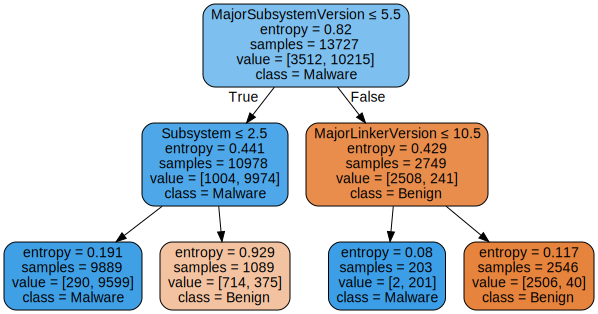

In [9]:
model = cart_depth_lim(0)
model.fit(X_train, y_train)
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model,
                           out_file = None, feature_names = list(X_train.columns.values),  
                           class_names=["Benign", "Malware"], filled = True, rounded = True, 
                           special_characters = True)

graph = graphviz.Source(dot_data)
graph

With all the preliminary work out of the way, we can proceed to introducing the phenomenon that prompted this "investigation". 

Let us plot a validation curve for an increasing limit on the tree depth with log loss as a performance metric alongside the same but with the classification performance evaluated by computing its accuracy. 

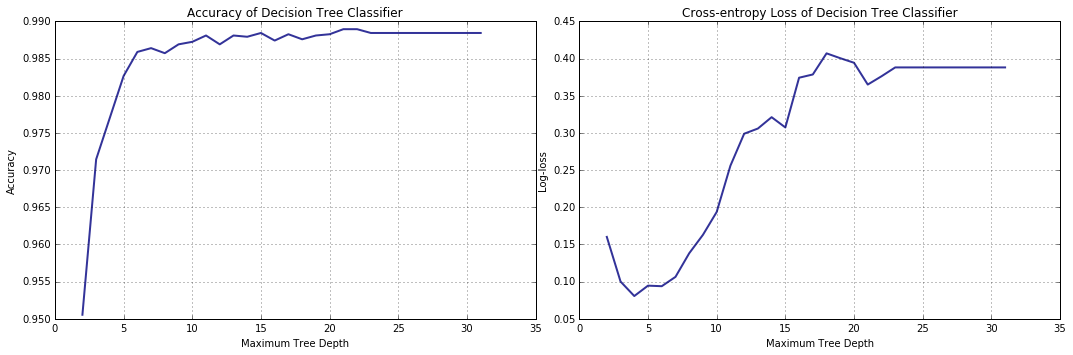

In [6]:
atrs, lsrs = collect_statistics(cart_depth_lim, [ lambda y, p, p0, p1: accuracy_score(y_val, y), 
                                                  lambda y, p, p0, p1: log_loss(y_val, p) ] )


set_figure_size(1, 2)

plt.subplot(1, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), atrs, color1, **lss)
plt.tight_layout()
plt.title("Accuracy of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), lsrs, color1, **lss)
plt.tight_layout()
plt.title("Cross-entropy Loss of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Log-loss")
plt.grid(True)
plt.show()

Surprisingly, beginning from a depth limit of 5, cross entropy that hitherto has been predictably decreasing, suddenly turns 180 degrees and starts growing. What is happening? Well, validation curve can change its curse "for the worse" as a result of overfitting; however, it does not seem to be the case here: firstly, a five-level-deep decision tree is not complex enough to overfit the training data we have and, secondly, the accuracy-based validation curve does not display a matching tendency. 


## Hypothesis I: a Trade-off Between Precision and Recall

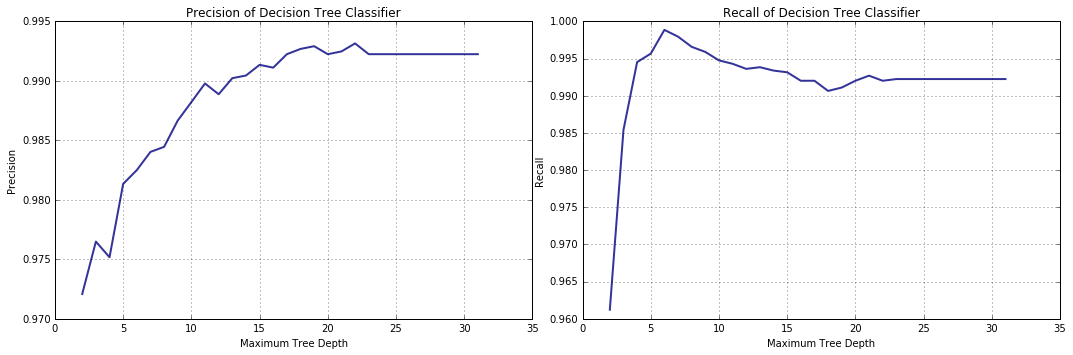

In [7]:
recs, precs = collect_statistics(cart_depth_lim, [ lambda y, p, p0, p1: recall_score(y_val, y), 
                                                   lambda y, p, p0, p1: precision_score(y_val, y) ] )

set_figure_size(1, 2)

plt.subplot(1, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), precs, color1, **lss)
plt.tight_layout()
plt.title("Precision of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Precision")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), recs, color1, **lss)
plt.tight_layout()
plt.title("Recall of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Recall")
plt.grid(True)
plt.show()

Our experience tells us: anomalies in values of classification performance metics can sometimes be explained by the interplay between precision and recall which are changing along with the model complexity. Indeed, precision and recall exhibit somewhat opposing behaviour. What is more, recall starts decreasing pretty early on (thereby making the more accurate models worse in some sense) and, where malware detection is concerned, recall is of utmost importance while false negatives are arguably more of a concern than false positives are, therefore the issue is worth our attention.

A cursory examination of the plots shows that recall is close to one at the tree depth just above 5, but we would do well to identify the (most likely) exact value of the parameter. For this purpose a 5-fold cross-validation procedure with the scoring metric set to "recall" will be used.

In [8]:
from sklearn.model_selection import GridSearchCV

parameters = { "max_depth" : cart_depth_lim_depths(stat_range) }
clf = GridSearchCV(DecisionTreeClassifier(criterion = "entropy", random_state = rs), 
                   parameters, cv = 5, scoring = 'recall')
clf.fit(X_train, y_train)
best_max_depth = clf.best_params_['max_depth']
print("Best value of max_depth:", best_max_depth)

model_best_recall = DecisionTreeClassifier(criterion = "entropy", random_state = rs, 
                                           max_depth = best_max_depth)
model_best_recall.fit(X_train, y_train)
yp = model_best_recall.predict(X_val)
print("Recall:", recall_score(y_val, yp))
print("Precision:", precision_score(y_val, yp))
print("Accuracy:", accuracy_score(y_val, yp))

Best value of max_depth: 6
Recall: 0.9988594890510949
Precision: 0.982499439084586
Accuracy: 0.9858939496940856


The benefit of using a cross-valadation technique is that it eliminates (at least to some extent) randomness by averaging over multiple splits thereby uncovering true trends. Even so, the depth thus determined is relatively small. The resulting model will likely be biassed; heavily constrained or simplified models lack the capacity to pick up on all but trivial regularities in data. In the worst case scenario, such model simply predicts the prevalent class (complitely ignoring the features).

In this case the situation is not that bad; however, high recall with comparatively low values of both, precision and accuracy, suggests that predictions contain very few false negatives and signifiantly more false positives. One possible explanation is that the labels are unevenly distributed, i.e. skewed towards the Malware class. As a result, in many cases, the weak model exhibits a tendency to choose the majority class. 

False positive and false negative predictions are easy to count.

In [9]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_val, model_best_recall.predict(X_val)).ravel()
print("Number of false positives:", fp)
print("Number of false negatives:", fn)

Number of false positives: 78
Number of false negatives: 5


The counts of false predictions seems to confirm our assumption. Let us now check if it was, in fact, correct.

In [10]:
print("Proportions of benign (negative) and malware (positive) binaries:", np.bincount(data["Malware"])/data.shape[0])
print("Null error rate:", np.bincount(data["Malware"])[0] / data.shape[0])
print("Error rate of the decision tree classifier:", 1.0 - atrs[cart_depth_lim_depths(stat_range).index(best_max_depth)])

Proportions of benign (negative) and malware (positive) binaries: [0.25557085 0.74442915]
Null error rate: 0.2555708530926521
Error rate of the decision tree classifier: 0.014106050305914386


It was! There are significantly more Malware points (as compared to that belonging to the Benign class) in the dataset. Though the decision tree is still much more powerful than the primitive classifier always predicting the majority class (its error rate is called "null error rate") as evident by the difference in the error rates.

How does this skew in label distribution affect the structure of decision?

In [11]:
import statistics as stat

def is_leaf(model, idx):
    return model.tree_.children_left[idx] < 0 and model.tree_.children_right[idx] < 0 

def tree_stats(model):
    #leaves where the tree places each datapoint
    leaf_ids = model.apply(X_train)
    
    #predicted classes indexed by leaf ids (from class predictions for each leaf)
    leaf_preds = [ is_leaf(model, i) and model.tree_.value[i][0][0] < model.tree_.value[i][0][1] 
                  for i in range(len(model.tree_.value)) ]
    
    leaves_cnt = sum([ is_leaf(model, i) for i in range(len(model.tree_.value)) ])
    pls_cnt = sum(leaf_preds) #positive (benign) leaves
    nls_cnt = leaves_cnt - pls_cnt #negative (malware) leaves
    
    #total number of datapoints assigned to all negative leaves
    nls = sum([ e[1] for e in enumerate(model.tree_.n_node_samples) if is_leaf(model, e[0]) and not leaf_preds[e[0]] ])
    #total number of datapoints assigned to all positive leaves
    pls = sum([ e[1] for e in enumerate(model.tree_.n_node_samples) if is_leaf(model, e[0]) and leaf_preds[e[0]] ])
    
    elements, counts = np.unique(leaf_ids[y_train == 0], return_counts = True)
    tn = dict(zip(elements, counts)) #true negative
    elements, counts = np.unique(leaf_ids[y_train == 1], return_counts = True)
    tp = dict(zip(elements, counts)) #true positive
    
    #average number of misclassified datapoints per negative leave 
    fn = stat.mean([ float(tp.get(i, 0)) for i in range(len(leaf_preds)) if not leaf_preds[i] ])
    #average number of misclassified datapoints per positive leave
    fp = stat.mean([ float(tn.get(i, 0)) for i in range(len(leaf_preds)) if leaf_preds[i] ])
    
    return (nls_cnt / leaves_cnt, nls/nls_cnt, fp), (pls_cnt / leaves_cnt, pls/pls_cnt, fn) 

def print_tree_stats(model):
    (nsp, spnl, epnl), (psp, sppl, eppl) = tree_stats(model)
    print("            proportion   sample per    misclassified")
    print("            of leaves    leaf          samples per leaf")
    print("Benign SW: %10.5f" %nsp,"  %10.5f"%spnl, "  %10.5f"%epnl, " (false positive)") 
    print("Malware  : %10.5f" %psp,"  %10.5f"%sppl, "  %10.5f"%eppl, " (false negative)")
    
print_tree_stats(model_best_recall)

            proportion   sample per    misclassified
            of leaves    leaf          samples per leaf
Benign SW:    0.44118    223.46667      8.63158  (false positive)
Malware  :    0.55882    546.05263      0.08333  (false negative)


In the decision tree, there are more leaves assigned "Malware" class (than "Benign"); per "Malware" leaf, there are more datapoints in the leaf, but fewer of them are classified incorrectly as compared to the "Benign" leaves, hence the model overall exhibits the tendency to prefer the "Malware" class in its predictions.

Perhaps, it will be instructive to see how the tree is constructed and, in particular, how nodes are split using the first (root) node as an example. It may help better understand the role the distribution of labels plays.

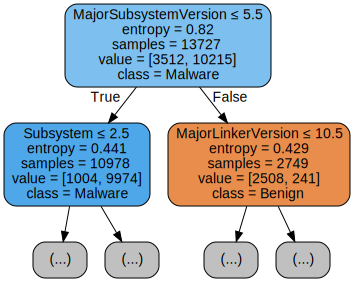

In [12]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model_best_recall,
                           max_depth = 1,
                           out_file = None, feature_names = list(X_train.columns.values),  
                           class_names=["Benign", "Malware"], filled = True, rounded = True, 
                           special_characters = True)

graph = graphviz.Source(dot_data)
graph

The split criterion (the feature which to split on) as well as the threshold value are chosen such that the information gain, i.e. difference between the entropy of the parent node and a weighted (by the proportion of points of the assigned class in the subnode) sum of the entropies of its two children is maximized. 

The entropy of a tree node is computed based on the frequentist estimate of the probabilities (`p0` and `p1`) that a random point in this node is either malware (`p1`) or benign software (`p0`), or, simply put, on the frequencies of datapoints of each class. The chunk of code below performs the computation.

In [13]:
def log(x):
    return np.log2(x) if x != 0.0 else 0.0

def compute_entropy_unweighted(y):
    n0, n1 = np.sum(y == 0), np.sum(y == 1)
    p0, p1 = n0 / (n0 + n1), n1 / (n0 + n1)
    return (n0, n1, -p0 * log(p0) - p1 * log(p1))

def compute_gain(feature, threshold, compute_entropy, *args):
    
    print("Split condition for the node: ", X_train.columns[feature], "<=", threshold)
    
    divider = X_train.iloc[:, feature]
    y_left = y_train[divider <= threshold]
    y_right = y_train[divider > threshold]

    n0, n1, h = compute_entropy(y_train, *args)
    print("Source node: value = [", n0, ",", n1, "]; entropy = ", h)
    nl0, nl1, hl = compute_entropy(y_left, *args)
    print("Left node: value = [", nl0, ",", nl1, "]; entropy = ", hl)
    nr0, nr1, hr = compute_entropy(y_right, *args)
    print("Righ node: value = [", nr0, ",", nr1, "]; entropy = ", hr)
    
    return h - ((y_left.shape[0]/y_train.shape[0]) * hl + (y_right.shape[0]/y_train.shape[0]) * hr)
    
print("Gain = ", compute_gain(model_best_recall.tree_.feature[0], 
                              model_best_recall.tree_.threshold[0], 
                              compute_entropy_unweighted))

Split condition for the node:  MajorSubsystemVersion <= 5.5
Source node: value = [ 3512 , 10215 ]; entropy =  0.8204132286187702
Left node: value = [ 1004 , 9974 ]; entropy =  0.4413099763029943
Righ node: value = [ 2508 , 241 ]; entropy =  0.42863845048023785
Gain =  0.38164088067497737


Observe that the resulting entropy values match those displayed on the tree diagram.

Designed specifically for datasets with uneven distribution of labels is a balanced decision tree that is created by passing the `class_weight` argument set to `"balanced"` to the `DecisionTreeClassifier`'s constructor.

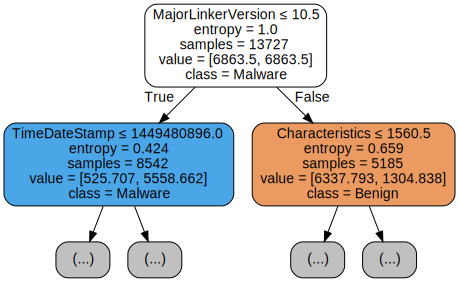

In [14]:
model_best_recall_bal = DecisionTreeClassifier(criterion = "entropy", random_state = rs, 
                                            max_depth = best_max_depth, class_weight = "balanced")
model_best_recall_bal.fit(X_train, y_train)
dot_data = export_graphviz(model_best_recall_bal,
                           max_depth = 1,
                           out_file = None, feature_names = list(X_train.columns.values),  
                           class_names=["Benign", "Malware"],  filled = True, rounded = True, 
                           special_characters = True)

graph = graphviz.Source(dot_data)
graph

_Let us ignore for now the fact that the TimeDateStamp feature found its way to the top tier while Characteristic, being an OR bitfield, should be treated differently. The topic of feature engineering, important though it is, lies beyond the scope of our discussion._

Notice that the number of datapoints assigned to the second-level nodes changed from (10978, 2749) to (8542, 5185) producing a more even split, which is accomplished by changing the way entropies are calculated. Below is a simplified version (the actual implementation is slightly more complicated) of the function that computes entropy. Therein, the frequencies used as estimates for the probabilities of a datapoint having Malware/Benign label are adjusted by class weights, each reverse proportional to the number of datapoints in the class. Though technically not completely correct, I like to think of it as datapoint counts for each class being adjusted to compensate for the uneven distribution of labels overall.  

To put it succintly, frequencies are corrected for the label imbalance.

In [15]:
weights = X_train.shape[0] / (2 * np.bincount(y_train))
print("Class Weights", weights)

def compute_entropy_balanced(y, w):
    n0, n1 = np.sum(y == 0) * w[0], np.sum(y == 1) * w[1]
    p0, p1 = n0 / (n0 + n1), n1 / (n0 + n1)
    return (n0, n1, -p0 * log(p0) - p1 * log(p1))

print("Gain = ", compute_gain(model_best_recall_bal.tree_.feature[0], 
                              model_best_recall_bal.tree_.threshold[0], 
                              compute_entropy_balanced, weights))

Class Weights [1.95429954 0.67190406]
Split condition for the node:  MajorLinkerVersion <= 10.5
Source node: value = [ 6863.5 , 6863.5 ]; entropy =  1.0
Left node: value = [ 525.7065774487471 , 5558.662310327949 ]; entropy =  0.4243475047893768
Righ node: value = [ 6337.793422551253 , 1304.8376896720508 ]; entropy =  0.6593753536591934
Gain =  0.48687713304918967


By the way, notice that the balanced and regular trees are split on different feautures at the root node: `MajorLinkerVersion` and `MajorSubsystemVersion` respectively. For the most curious of you, plotted below are the information gain for both of them computed in the setting of regular and belanced trees. It is easy to see that information gain for the split on `MajorSubsystemVersion` decreased, whereas the same for `MajorLinkerVersion` increased (at their respective maxima), which prompted the criterion change.

In [16]:
%%capture
def compute_info_gain_range(ft):
    thr_seq = np.unique(X_train.iloc[:, ft])[:-1]
    gns = [ compute_gain(ft, t, compute_entropy_unweighted) for t in thr_seq ]
    gnws = [ compute_gain(ft, t, compute_entropy_balanced, weights) for t in thr_seq ]
    return thr_seq, gns, gnws
    
fsq, gns, gnws = compute_info_gain_range(model_best_recall.tree_.feature[0])
fsq_b, gns_b, gnws_b = compute_info_gain_range(model_best_recall_bal.tree_.feature[0])

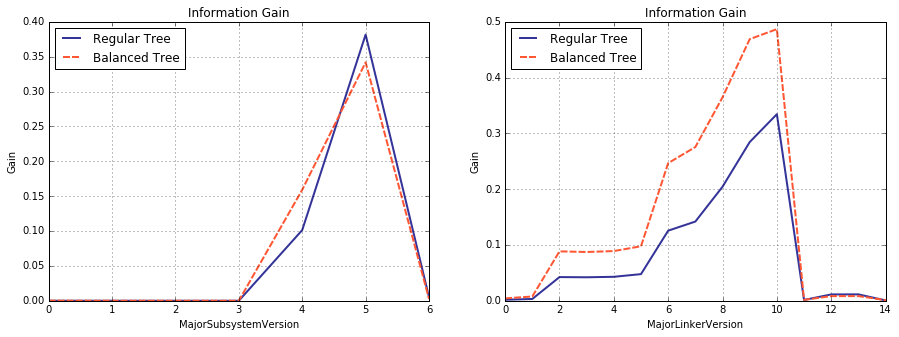

In [17]:
set_figure_size(1, 2)

plt.subplot(1, 2, 1)
plt.plot(fsq, gns, color1, **lss)
plt.plot(fsq, gnws, color2, **lss2)
plt.title("Information Gain")
plt.xlabel(X_train.columns[model_best_recall.tree_.feature[0]])
plt.ylabel("Gain")
plt.grid(True)
plt.legend(["Regular Tree", "Balanced Tree"], loc = "upper left")

plt.subplot(1, 2, 2)
plt.plot(fsq_b, gns_b, color1, **lss)
plt.plot(fsq_b, gnws_b, color2, **lss2)
plt.xlim(0, 14)
plt.title("Information Gain")
plt.xlabel(X_train.columns[model_best_recall_bal.tree_.feature[0]])
plt.ylabel("Gain")
plt.legend(["Regular Tree", "Balanced Tree"], loc = "upper left")
plt.grid(True)
plt.show()

Let us run the `print_tree_stats()` once more, but this time for the balanced tree, and see what has changed.

In [18]:
print_tree_stats(model_best_recall_bal)

            proportion   sample per    misclassified
            of leaves    leaf          samples per leaf
Benign SW:    0.47500    183.26316      4.61905  (false positive)
Malware  :    0.52500    487.85714      1.15517  (false negative)


There are still more leaves assigned a positive class in the tree; as before, Malware-labelled leaves contain more datapoint per leaf (after all, the data itself did not change -- all the Malware had to go somewhere). What the new way of computing the entropy did is improving the balance between false positives and false negatives by redistributing the "positive" and "negative" datapoints among the nodes.

Now we shall see the effect the balancing had on precision and recall.

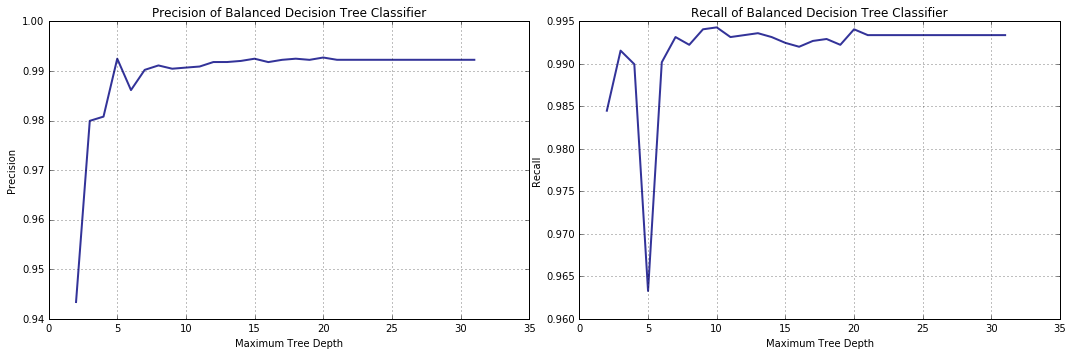

In [19]:
cart_depth_lim_bal = lambda i: DecisionTreeClassifier(criterion = "entropy", class_weight = "balanced", 
                                                      max_depth = i + 2, random_state = rs)

recs_b, precs_b = collect_statistics(cart_depth_lim_bal, [ lambda y, p, p0, p1: recall_score(y_val, y), 
                                                           lambda y, p, p0, p1: precision_score(y_val, y) ] )

set_figure_size(1, 2)

plt.subplot(1, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), precs_b, color1, **lss)
plt.tight_layout()
plt.title("Precision of Balanced Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Precision")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), recs_b, color1, **lss)
plt.tight_layout()
plt.title("Recall of Balanced Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Recall")
plt.grid(True)
plt.show()

The recall score no longer displays a pronounced decrease trend as the limit on the tree depth grows. 

As a side note, for the datasets with unbalanced labels, it is recommended to use `balanced_accuracy()` instead of `accuracy()`, provided all the classes are treated on equal footing. Validation curves for both are plotted below.

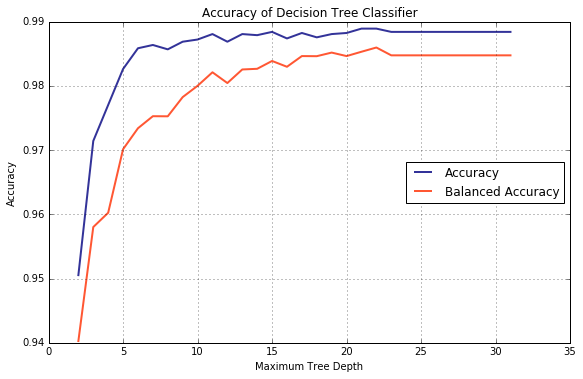

In [20]:
from sklearn.metrics import balanced_accuracy_score

#comma after batrs "unpacks" the tuple returned by collect_statistics()
batrs, = collect_statistics(cart_depth_lim, [ lambda y, p, p0, p1: balanced_accuracy_score(y_val, y) ] )

set_figure_size(1, 1)

plt.plot(cart_depth_lim_depths(stat_range), atrs, color1, cart_depth_lim_depths(stat_range), batrs, color2, **lss)
plt.tight_layout()
plt.title("Accuracy of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Balanced Accuracy"], loc = "center right")
plt.grid(True)

I have some news for you -- as luck would have it, good and bad. The good news is that we have found a solution for the falling recall problem. The bad news is that it is not the problem we were trying to solve. The recall's decrease trend could not be the reason why cross entropy degrades due to magnitude of decrease in recall's value not being high enough to overpower the raising precision. In particular, the log-loss formula is symmetric relative to the probabilities of each class, therefore it should be affected by both types of misclassification errors, false positives and false negatives, in equal measure. Another example of symmetry is F1 score and symmetric it is relative to the precision and recall values.     

We will plot two validation curves: one, F1 score-based, for the regular decision tree, and another -- the familiar log-loss, but for the balanced tree and you will see that the recall trend, weak as it is, has no definitive effect on either. 

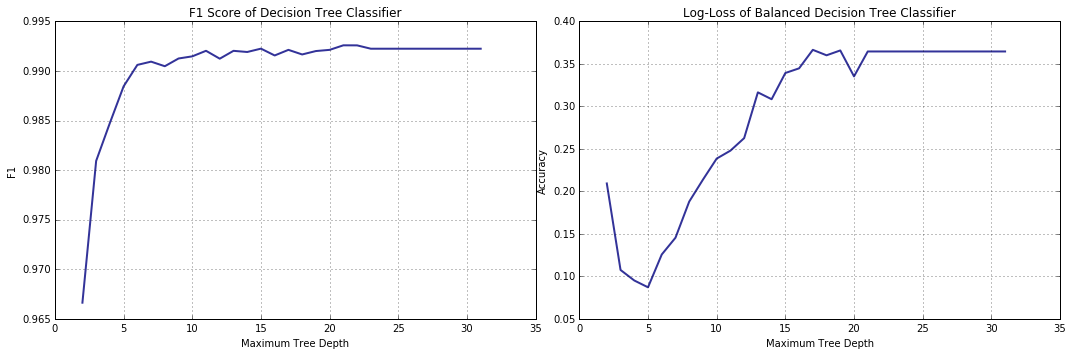

In [21]:
#comma after batrs "unpacks" the tuple returned by collect_statistics()
f1s, = collect_statistics(cart_depth_lim, [ lambda y, p, p0, p1: f1_score(y_val, y) ] )

cart_depth_lim_bal = lambda i: DecisionTreeClassifier(criterion = "entropy", class_weight = "balanced", 
                                                      max_depth = i + 2, random_state = rs)
atrs_b, = collect_statistics(cart_depth_lim_bal, [ lambda y, p, p0, p1: log_loss(y_val, p) ] )

set_figure_size(1, 2)

plt.subplot(1, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), f1s, color1, **lss)
plt.tight_layout()
plt.title("F1 Score of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("F1")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), atrs_b, color1, **lss)
plt.tight_layout()
plt.title("Log-Loss of Balanced Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

Why did we spend so much time on working out the hypothesis, so clearly wrong? As I have already mentioned, recall is an important measure for malware detection and, as such, merits its own little investigation. 

Consider it a red herring if you must...


## Hypothesis II: Log-loss' Idiosyncrasy

So what is actually going on?

To begin with, consider how the confidence of a classification algorithm in its predictions changes as the underlying model gains predictive power (i.e the capacity to model larger datasets). In order to answer the question let us plot the proportion of (0, 1) (or (1, 0)) pairs of probabilities returned by `predict_proba()` method of the estimator.

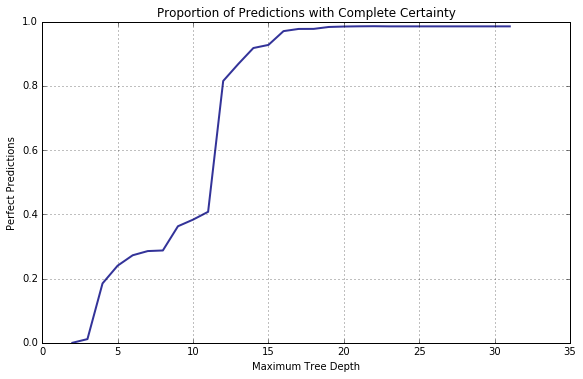

In [22]:
tcs, = collect_statistics(cart_depth_lim, 
                          [ lambda y, p, p0, p1: (np.count_nonzero(p1 == 1.0) + np.count_nonzero(p0 == 1.0)) / y.shape[0] ] )

set_figure_size(1, 1)

plt.plot(cart_depth_lim_depths(stat_range), tcs, color1, **lss)
plt.tight_layout()
plt.title("Proportion of Predictions with Complete Certainty")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Perfect Predictions")
plt.grid(True)
plt.show()

With its depth growing, the decision tree becomes increasingly more confident in its decisions. 

However confident we are in our prediction, it can still be wrong. Let us trace the error dynamics by plotting false positive and false negative error rates for the validation set against an increasing tree depth. Among the false predictions, a special place is held by what I call "errors [made] with perfect confidence" where the decision tree estimated the probability of its guess being correct as 1. 

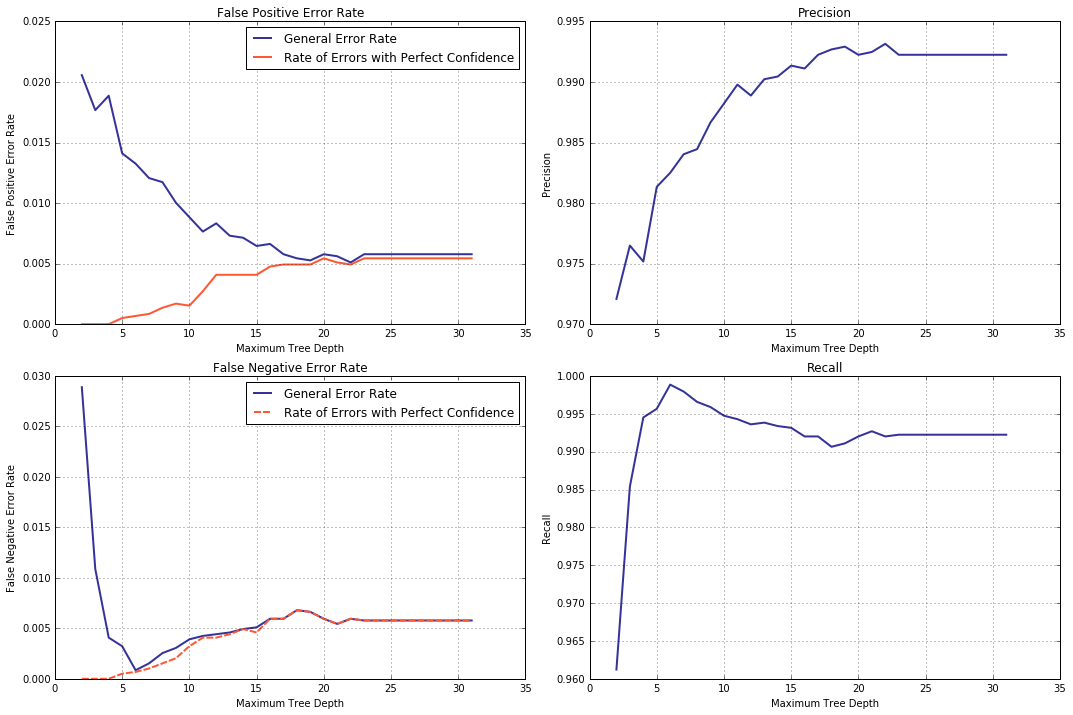

In [23]:
err0, err1, errf0, errf1 = collect_statistics(cart_depth_lim, 
    [ lambda y, p, p0, p1: np.sum(p[y_val == 0, 0] == 0.0)/y.shape[0], #false positive with perfect confidence error rate
      lambda y, p, p0, p1: np.sum(p[y_val == 1, 1] == 0.0)/y.shape[0], #false negative with perfect confidence erroe rate
      lambda y, p, p0, p1: np.sum(p[y_val == 0, 0] < 0.5)/y.shape[0], #false positive error rate
      lambda y, p, p0, p1: np.sum(p[y_val == 1, 1] < 0.5)/y.shape[0] ]) #false negative error rate

set_figure_size(2, 2)

plt.subplot(2, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), errf0, color1, cart_depth_lim_depths(stat_range), err0, color2, **lss)
plt.tight_layout()
plt.title("False Positive Error Rate")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("False Positive Error Rate")
plt.legend(["General Error Rate", "Rate of Errors with Perfect Confidence"])
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), precs, color1, **lss)
plt.tight_layout()
plt.title("Precision")
plt.ylabel("Precision")
plt.xlabel(cart_depth_lim_depths_name)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(cart_depth_lim_depths(stat_range), errf1, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), err1, color2,  **lss2)
plt.tight_layout()
plt.title("False Negative Error Rate")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("False Negative Error Rate")
plt.legend(["General Error Rate", "Rate of Errors with Perfect Confidence"])
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(cart_depth_lim_depths(stat_range), recs, color1, **lss)
plt.tight_layout()
plt.title("Recall")
plt.ylabel("Recall")
plt.xlabel(cart_depth_lim_depths_name)
plt.grid(True)

plt.show()

Predictably, trends of false positive and false negative error rates mirror that of precision and recall respectively: namely, FP error rate decreases while precision grows and, FN error rate, dropping at first, shows a gradual increase, which is matched by a rise with subsequent slow decrease in recall. Interesting here is the growth trend displayed by error rates with perfect confidence for both classes. We can, thus, reformulate our earlier conclusion as: with its depth growing, the decision tree becomes increasingly more confident in its blunders. Of course, the mechanism by which it happens is well understood (or rather, can be understood with ease after a quick deliberation). 

Remember, a datapoint is classified by being moved down the tree (in accordance with the values of its features and conditions at the tree nodes) until it reaches a leaf. The probability of a datapoint belonging to a particular class is computed as a proportion of the training-set datapoints of the said class that share a leaf with the point being classified. 

As a demonstration, we will obtain the probabilities from sklearn, compute the same by hand and then compare the two. 

In [24]:
p = model_best_recall.predict_proba(X_val)

#index of a datapoint with probabbilities in (0.1, 0.9)
idx = np.where(np.abs(p[:, 0] - 0.5) < 0.4)[0][0]

print("Predicted probabilities of belonging to Benign/Malware classes are", p[idx, :])

leaf_id = model_best_recall.apply(X_val.iloc[idx : idx + 1, :])[0]

print("The Deision Tree places this datapoint to a leaf with an index of", leaf_id)

print("The leaf contains", model_best_recall.tree_.n_node_samples[leaf_id], "datapoints, of which", 
      model_best_recall.tree_.value[leaf_id][0][0], "are benign and", 
      model_best_recall.tree_.value[leaf_id][0][1], "- malware.")

print("The number of benign and malware datapoints in proportion to the total number of datapoints assigned to the leaf:\n", 
      model_best_recall.tree_.value[leaf_id][0][0]/model_best_recall.tree_.n_node_samples[leaf_id], "and",
      model_best_recall.tree_.value[leaf_id][0][1]/model_best_recall.tree_.n_node_samples[leaf_id], "respectively.")

Predicted probabilities of belonging to Benign/Malware classes are [0.22857143 0.77142857]
The Deision Tree places this datapoint to a leaf with an index of 30
The leaf contains 210 datapoints, of which 48.0 are benign and 162.0 - malware.
The number of benign and malware datapoints in proportion to the total number of datapoints assigned to the leaf:
 0.22857142857142856 and 0.7714285714285715 respectively.


As the tree grows, fewer and fewer nodes contain representatives of both classes and, consequently, more and more datapoints can be classified with perfecct confidence, but, of course, this confidence concerns the training data only. It is when the tree has to deal with the data it has not yet seen that "errors with perfect confidence" occur. 

If you are not completely convinced, let us for a sample of the same size as before, but taken from the training dataset, plot accuracy, log loss, positive/negative error rates and the same "with perfect confidence" against the limit on tree depth.  

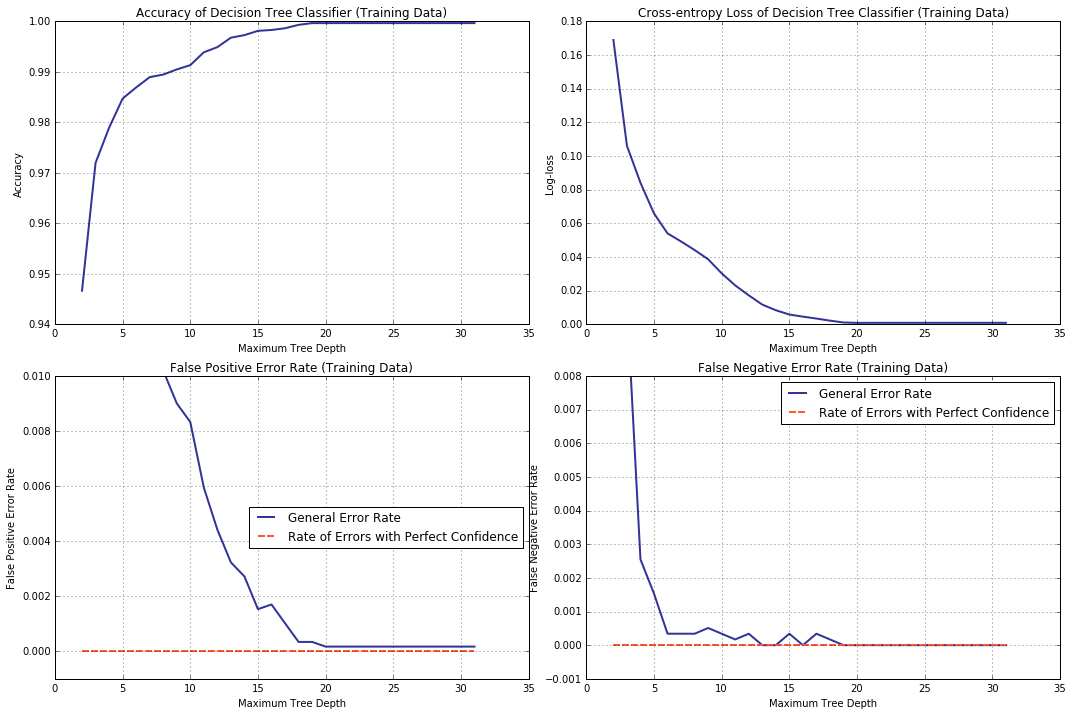

In [25]:
from numpy.random import randint

idx = randint(0, X_train.shape[0], X_val.shape[0])

new_X_val = X_train.iloc[idx, :]
new_y_val = y_train.iloc[idx]

t_atrs, t_lsrs, t_err0, t_err1, t_errf0, t_errf1 = collect_statistics(cart_depth_lim, 
    [ lambda y, p, p0, p1: accuracy_score(new_y_val, y), 
      lambda y, p, p0, p1: log_loss(new_y_val, p),
      lambda y, p, p0, p1: np.sum(p[new_y_val == 0, 0] == 0.0)/y.shape[0],
      lambda y, p, p0, p1: np.sum(p[new_y_val == 1, 1] == 0.0)/y.shape[0], 
      lambda y, p, p0, p1: np.sum(p[new_y_val == 0, 0] < 0.5)/y.shape[0],
      lambda y, p, p0, p1: np.sum(p[new_y_val == 1, 1] < 0.5)/y.shape[0] ], 
    Xval = new_X_val, yval = new_y_val) # <--- !!!

set_figure_size(2, 2)

plt.subplot(2, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), t_atrs, color1, **lss)
plt.tight_layout()
plt.title("Accuracy of Decision Tree Classifier (Training Data)")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), t_lsrs, color1, **lss)
plt.tight_layout()
plt.title("Cross-entropy Loss of Decision Tree Classifier (Training Data)")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel('Log-loss')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(cart_depth_lim_depths(stat_range), t_errf0, color1, **lss) 
plt.plot(cart_depth_lim_depths(stat_range), t_err0, color2, **lss2)
plt.tight_layout()
plt.title("False Positive Error Rate (Training Data)")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("False Positive Error Rate")
plt.legend(["General Error Rate", "Rate of Errors with Perfect Confidence"], loc = "center right")
plt.ylim(-0.001, 0.01)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(cart_depth_lim_depths(stat_range), t_errf1, color1, **lss) 
plt.plot(cart_depth_lim_depths(stat_range), t_err1, color2, **lss2)
plt.tight_layout()
plt.title("False Negative Error Rate (Training Data)")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("False Negative Error Rate")
plt.legend(["General Error Rate", "Rate of Errors with Perfect Confidence"], loc = "upper right")
plt.ylim(-0.001, 0.008)
plt.grid(True)
plt.show()

plt.show()

What do we observe? Rates of errors with perfect confidence stay at zero, error rates associated with false positive and false negative predictions, both, decrease and, more to the point, cross entropy displays a decrease trend that neatly mirrows that for the accuracy. 

Obviously, these "overconfident" errors are the culprits in this situation. The sheer audacity of them!..

To see why, recall how log loss is computed. Given the actual class of a response variable ($y \in \{0, 1\}$) and the estimated probability of its predicted class being "1" ($p$), the log loss is defined as follows:
$$l(y, p) = - y \cdot log(p) - (1 - y) \cdot log(1 - p)$$

In case when an error with perfect confidence is comitted, the resulting log loss will include the term $1 \cdot log(0)$ and $log(0)$ is not defined. How does sklearn bypass the problem? Here is an exerpt from the library's [source code](https://github.com/scikit-learn/scikit-learn/blob/80598905e517759b4696c74ecc35c6e2eb508cff/sklearn/metrics/_classification.py#L2426) 

```
def log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None):
    
    #[...]
    
    # Clipping
    y_pred = np.clip(y_pred, eps, 1 - eps)
```
That is, by default, $p=0$ are simply clipped out, being replaced by $p=1e-15$. Although far from infinity, the value of $-log(1e-15) = 34.5388$ is still relatively large (however, keep in mind that its impact is lessened by the fact that log loss is averaged across all datapoints in the sample). In order to assess the effect it has on the total log loss of a sample, let us try another substitute for log(0) -- 0.  

For starters, we will plot partial log loss computed for each of the classes, Benign and Malware, separately. We will also compute log loss the sklearn's way, for comparison. 

In [26]:
ll0, ll1, ll = collect_statistics(cart_depth_lim, 
    [ lambda y, p, p0, p1: np.sum(-np.log(p0, out = np.zeros_like(p0), where = ( p0 != 0.0 )))/p0.shape[0],
      lambda y, p, p0, p1: np.sum(-np.log(p1, out = np.zeros_like(p1), where = ( p1 != 0.0 )))/p1.shape[0], 
      lambda y, p, p0, p1: (np.sum(-np.log(p0, out = np.zeros_like(p0), where = ( p0 != 0.0 ))) + 
                            np.sum(-np.log(p1, out = np.zeros_like(p1), where = ( p1 != 0.0 ))))/y.shape[0] ])

ll_eps = 1e-15

def log_loss_sklean_0(p0):
    p0_cl = np.clip(p0, ll_eps, 1.0 - ll_eps)
    return np.sum(-np.log(p0_cl))/p0.shape[0]

def log_loss_sklean_1(p1):
    p1_cl = np.clip(p1, ll_eps, 1.0 - ll_eps)
    return np.sum(-np.log(p1_cl))/p1.shape[0]
    
def log_loss_sklean(p0, p1):
    p0_cl = np.clip(p0, ll_eps, 1.0 - ll_eps)
    p1_cl = np.clip(p1, ll_eps, 1.0 - ll_eps)
    return (np.sum(-np.log(p0_cl)) + np.sum(-np.log(p1_cl)))/(p0.shape[0] + p1.shape[0])

llsk0, llsk1, llsk = collect_statistics(cart_depth_lim, [ lambda y, p, p0, p1: log_loss_sklean_0(p0), 
                                                          lambda y, p, p0, p1: log_loss_sklean_1(p1),
                                                          lambda y, p, p0, p1: log_loss_sklean(p0, p1) ])

And now we plot it all...

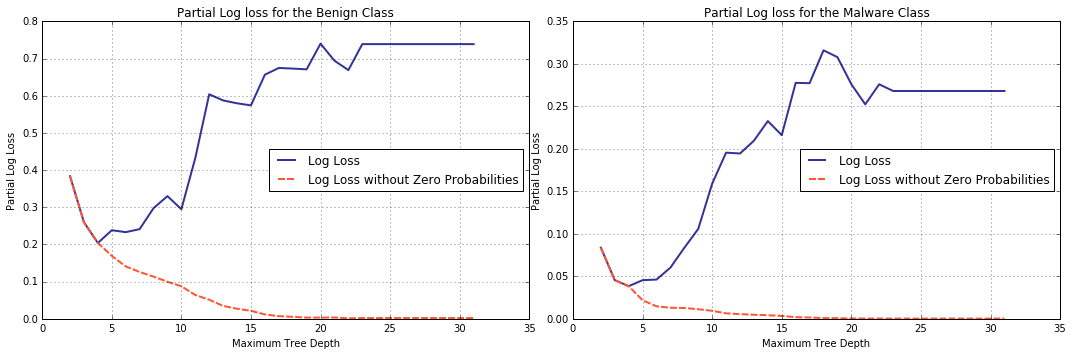

In [34]:
set_figure_size(1, 2)

plt.subplot(1, 2, 1)
plt.plot(cart_depth_lim_depths(stat_range), llsk0, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), ll0, color2, **lss2)
plt.tight_layout()
plt.title("Partial Log loss for the Benign Class")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Partial Log Loss")
plt.legend(["Log Loss", "Log Loss without Zero Probabilities"], loc = "center right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cart_depth_lim_depths(stat_range), llsk1, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), ll1, color2, **lss2)
plt.tight_layout()
plt.title("Partial Log loss for the Malware Class")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Partial Log Loss")
plt.legend(["Log Loss", "Log Loss without Zero Probabilities"], loc = "center right")
plt.grid(True)
plt.show()

Zero probabilities (and with them, disproportionately large log(eps)) eliminated, the tendency of cross-entropy metric changes to the opposite and this behaviour is independent of the class, Benign or Malware. 

It should come as no surprise that this behaviour is preserved when partial log losses are combined.

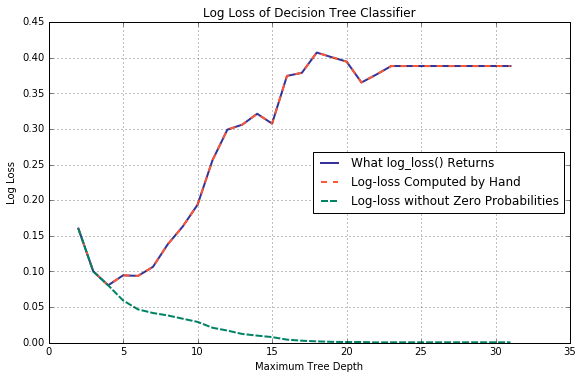

In [37]:
set_figure_size(1, 1)

plt.plot(cart_depth_lim_depths(stat_range), lsrs, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), llsk, color2, ls = "--", **lss)
plt.plot(cart_depth_lim_depths(stat_range), ll, color3, **lss2)
plt.tight_layout()
plt.title("Log Loss of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Log Loss")
plt.legend(["What log_loss() Returns", "Log-loss Computed by Hand", "Log-loss without Zero Probabilities"], loc = "center right")
plt.grid(True)
plt.show()

If for whatever reason, the engineer still insists on using cross entropy as a performance metric, there is a way of mitigating the effect. As you, no doubt, have already guessed, it can be accomplished by increasing the value of paremeter `eps` passed to `log_loss()`. Let us plot a family of validation curves for multiple values of `eps`.

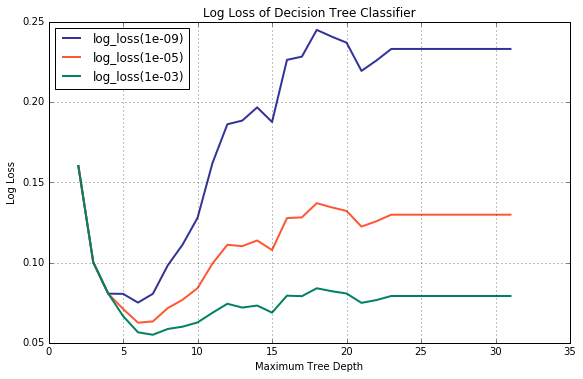

In [29]:
eps1 = 1e-9
eps2 = 1e-5
eps3 = 1e-3
llske1, llske2, llske3 = collect_statistics(cart_depth_lim, [ lambda y, p, p0, p1: log_loss(y_val, p, eps = eps1), 
                                                              lambda y, p, p0, p1: log_loss(y_val, p, eps = eps2),
                                                              lambda y, p, p0, p1: log_loss(y_val, p, eps = eps3) ])

set_figure_size(1, 1)

plt.plot(cart_depth_lim_depths(stat_range), llske1, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), llske2, color2, **lss)
plt.plot(cart_depth_lim_depths(stat_range), llske3, color3, **lss)
plt.tight_layout()
plt.title("Log Loss of Decision Tree Classifier")
plt.xlabel(cart_depth_lim_depths_name)
plt.ylabel("Log Loss")
plt.legend(["log_loss(%.0e)"%eps1, "log_loss(%.0e)"%eps2, "log_loss(%.0e)"%eps3], loc = "upper left")
plt.grid(True)
plt.show()

Off the top of one's head, it is hard to say whether this phenomenon is specific to decision trees and how pervasive it is overall, but, naturally, not all models suffer from this "affliction". Consider, for example, AdaBoost. For an ensemble classifier the number of weak learners it employs would be a suitable measure of its complexity, hence this is what we choose to plot the validation curve against. 

Examining the plots below, notice that the error rates with perfect confidence stay at zero while cross entropy decreases. 

In [41]:
from sklearn.ensemble import AdaBoostClassifier

ada_class_num_lim = lambda i: AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 8, random_state = rs),
                                                 n_estimators = i + 1, random_state = rs)
ada_classifier_nums = lambda x: [ i + 1 for i in x ]

In [42]:
a_atrs, a_lsrs, a_recs, a_precs, a_err0, a_err1, a_errf0, a_errf1, a_ll0, a_ll1, a_llsk0, a_llsk1 = collect_statistics(
    ada_class_num_lim, 
    [ lambda y, p, p0, p1: accuracy_score(y_val, y), 
      lambda y, p, p0, p1: log_loss(y_val, p),
      lambda y, p, p0, p1: recall_score(y_val, y), 
      lambda y, p, p0, p1: precision_score(y_val, y),
      lambda y, p, p0, p1: np.sum(p[y_val == 0, 0] == 0.0)/y.shape[0],
      lambda y, p, p0, p1: np.sum(p[y_val == 1, 1] == 0.0)/y.shape[0], 
      lambda y, p, p0, p1: np.sum(p[y_val == 0, 0] < 0.5)/y.shape[0],
      lambda y, p, p0, p1: np.sum(p[y_val == 1, 1] < 0.5)/y.shape[0], 
      lambda y, p, p0, p1: np.sum(-np.log(p0, out = np.zeros_like(p0), where = ( p0 != 0.0 )))/p0.shape[0],
      lambda y, p, p0, p1: np.sum(-np.log(p1, out = np.zeros_like(p1), where = ( p1 != 0.0 )))/p1.shape[0], 
      lambda y, p, p0, p1: log_loss_sklean_0(p0), 
      lambda y, p, p0, p1: log_loss_sklean_1(p1) ])

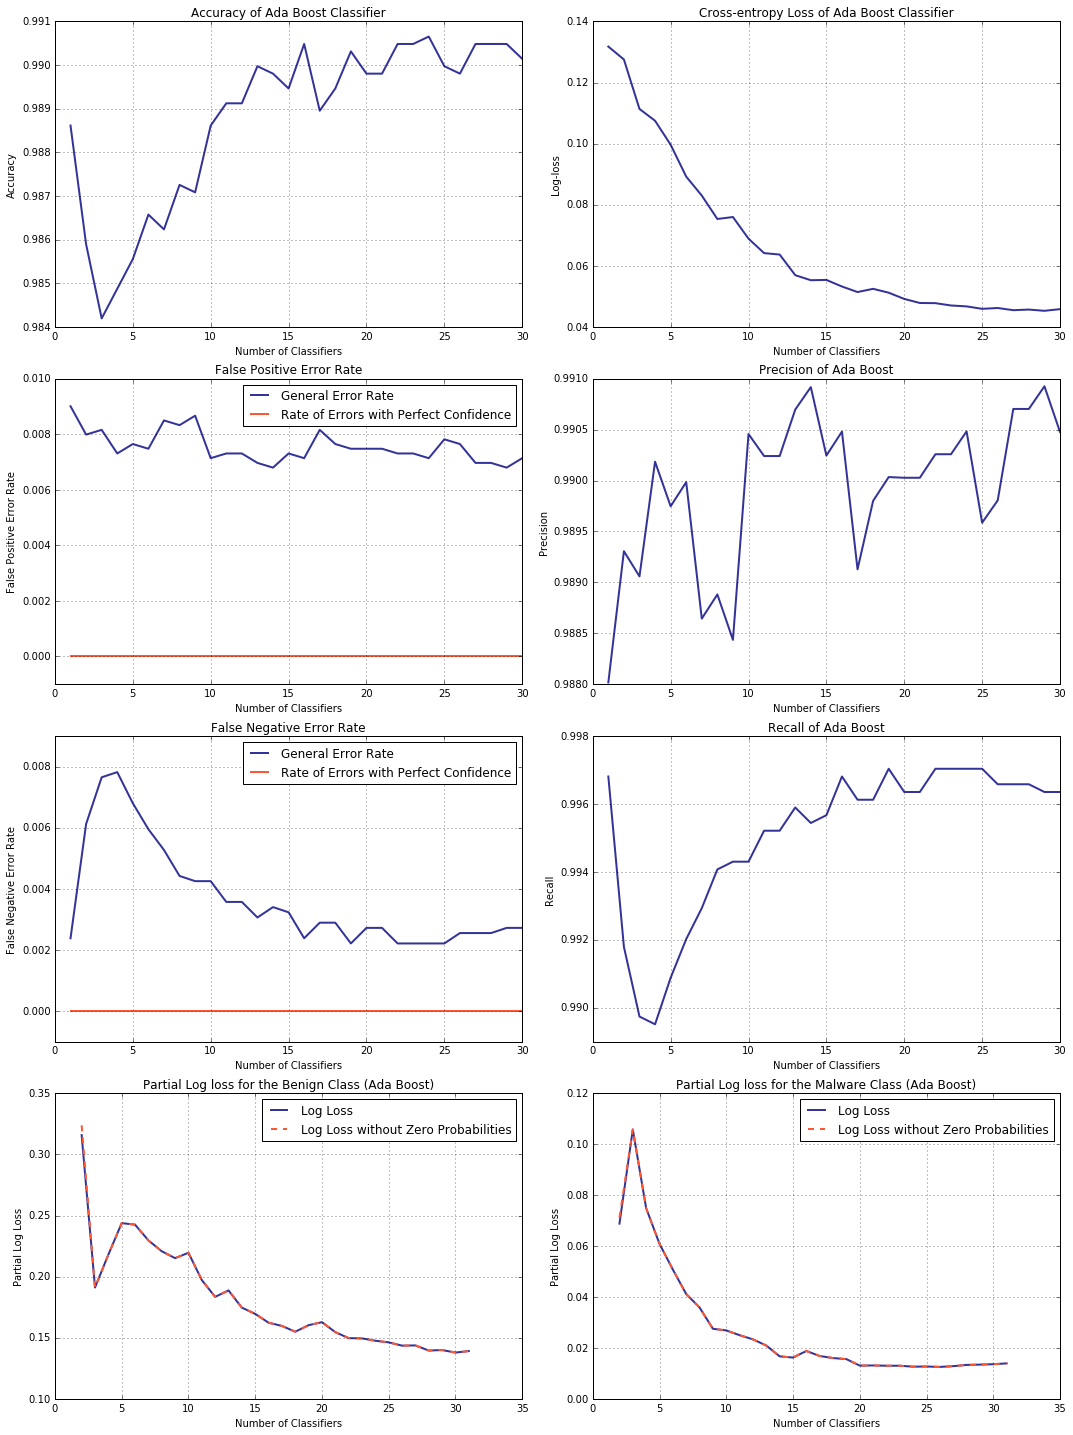

In [43]:
set_figure_size(4, 2)

plt.subplot(4, 2, 1)
plt.plot(ada_classifier_nums(stat_range), a_atrs, color1, **lss)
plt.tight_layout()
plt.title("Accuracy of Ada Boost Classifier")
plt.xlabel("Number of Classifiers")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(ada_classifier_nums(stat_range), a_lsrs, color1, **lss)
plt.tight_layout()
plt.title("Cross-entropy Loss of Ada Boost Classifier")
plt.xlabel("Number of Classifiers")
plt.ylabel("Log-loss")
plt.grid(True)

plt.subplot(4, 2, 3)
plt.plot(ada_classifier_nums(stat_range), a_errf0, color1, ada_classifier_nums(stat_range), a_err0, color2, **lss)
plt.tight_layout()
plt.title("False Positive Error Rate")
plt.xlabel("Number of Classifiers")
plt.ylabel("False Positive Error Rate")
plt.ylim(-0.001, 0.010)
plt.legend(["General Error Rate", "Rate of Errors with Perfect Confidence"])
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(ada_classifier_nums(stat_range), a_precs, color1, **lss)
plt.tight_layout()
plt.title("Precision of Ada Boost")
plt.ylabel("Precision")
plt.xlabel("Number of Classifiers")
plt.grid(True)

plt.subplot(4, 2, 5)
plt.plot(ada_classifier_nums(stat_range), a_errf1, color1, **lss)
plt.plot(ada_classifier_nums(stat_range), a_err1, color2,  **lss)
plt.tight_layout()
plt.title("False Negative Error Rate")
plt.xlabel("Number of Classifiers")
plt.ylabel("False Negative Error Rate")
plt.legend(["General Error Rate", "Rate of Errors with Perfect Confidence"])
plt.ylim(-0.001, 0.009)
plt.grid(True)

plt.subplot(4, 2, 6)
plt.plot(ada_classifier_nums(stat_range), a_recs, color1, **lss)
plt.tight_layout()
plt.title("Recall of Ada Boost")
plt.ylabel("Recall")
plt.xlabel("Number of Classifiers")
plt.grid(True)

plt.subplot(4, 2, 7)
plt.plot(cart_depth_lim_depths(stat_range), a_llsk0, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), a_ll0, color2, **lss3)
plt.tight_layout()
plt.title("Partial Log loss for the Benign Class (Ada Boost)")
plt.xlabel("Number of Classifiers")
plt.ylabel("Partial Log Loss")
plt.legend(["Log Loss", "Log Loss without Zero Probabilities"], loc = "upper right")
plt.grid(True)

plt.subplot(4, 2, 8)
plt.plot(cart_depth_lim_depths(stat_range), a_llsk1, color1, **lss)
plt.plot(cart_depth_lim_depths(stat_range), a_ll1, color2, **lss3)
plt.tight_layout()
plt.title("Partial Log loss for the Malware Class (Ada Boost)")
plt.xlabel("Number of Classifiers")
plt.ylabel("Partial Log Loss")
plt.legend(["Log Loss", "Log Loss without Zero Probabilities"], loc = "upper right")
plt.grid(True)
plt.show()

In the end, an interplay between decreasing error rate and increasing confidence in incorrect predictions (where the latter was overtaking) turned out to be at the core of inconsistency between the accuracy and log loss trends.